# Hexapod 

This is an example code for how to simulate and train the hexapod body-affordance model. You will need:

- pybullet
- pytorch (either 0.1.12 or 0.2.0 is okay)

Generally this model is a bit difficult to train in a run-once-and-done fashion. Instead, training generally goes according to the following procedure:

### Gather data
Gather random playout data to train the initial predictor (about 10000-15000 playouts is good to avoid overfitting the initial predictor model).

### Train predictor
Train the predictor to convergence. You can start with a learning rate of 1e-3 and gradually anneal towards 1e-4 to improve the accuracy. You want an error below 0.5, and getting it down to 0.4 is possible with patience.

### Train proposer
Train the proposer to convergence. If you have initial problems with the control mesh forming one big clump, it can be useful to turn off the regularization at first, and then increase it during training once the mesh has separated out a bit. Generally at this point, if you check the actual outcomes versus the predicted ones, the predictions should look fairly smooth and evenly spread out, but the actual outcomes will be a tangled mess.

### Gather proposer-specific data
Generate 1000 playouts using the proposer's policy plus a bit of noise rather than a random policy and add it to the predictor's training set.

### Repeat
Repeat training the predictor and the proposer for 5-10 of these cycles, until you get reasonable agreement between the predictions and outcomes after training the proposer but before training the predictor again.

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

import time
import glob
import sys

from math import *
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable

import copy
from multiprocessing import Pool

import IPython.display as display

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

import pybullet as p

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Some global variables

# This is the length of the playouts we use during data collection
# It can help the predictor to generalize if we collect and train on longer playouts than
# we expect the proposer to generate, since the proposer will tend to manage to make more extreme
# values than the initial random playouts, and this gives the robot a bit more chance to wander
# away from the initial configuration
LEN = 10

# Number of actuators, sensors, etc. This is to avoid mystery numbers littering the code,
# but changing it only makes sense if you change the robot body and also the stuff in Simulation()
# that explicitly constructs the sensor states and applies the actions
ACTUATORS = 2*18
SENSORS = 6+18

# Number of hidden neurons for the proposer layers. 
HIDDEN = 128

# Number of hidden neurons for the predictor layers. If you have the time to collect the data and
# train, making this bigger will often improve the precision of the final control policies.
# This size is good for about 20000 playouts
HIDDEN2 = 256

### Predictor network

The general structure of the predictor network takes as input: the current sensor values, the uncertainty of the current sensor values (for when the predictor is fed recurrently into itself), and the next action. It then predicts the means $\hat{\mu}$ and standard deviations $\hat{\sigma}$ for the next set of sensor values. Because the standard deviation should be strictly positive and we want to explore values asymptotically close to zero, we're going to write the standard deviation as a function of the network output $\hat{y_\sigma}$:

$\hat{\sigma^2} = ELU(\hat{y_\sigma})+1$

where ELU is the exponential linear unit activation (which exponentially decays towards -1 as its argument goes to -infinity, and is linear as its argument goes to +infinity). This is more convenient than squaring $\hat{y_\sigma}$ because it does not introduce a degeneracy between positive and negative values.

In order to train this the network, we maximize the log likelihood of the actual subsequent sensor values $y$ in terms of the Gaussian distributions with the predicted mean and standard deviation. This results in a loss:

$L = \frac{1}{\hat{\sigma^2}} (y-\hat{y_\mu})^2 - \frac{1}{2} \log \hat{\sigma^2}$

This lets the network learn to estimate its own uncertainty.

In terms of the network architecture, we use multiple dense layers with skip connections, including predicting the change between future and current sensor values rather than predicting the future sensor values directly. This basically helps the network train faster, and also helps the predictor learn on longer sequences without experiencing problems due to  vanishing gradients.

In [3]:
class Predict(nn.Module):
    def __init__(self):
        super(Predict,self).__init__()
        
        # We use 1d convolutional layers here with a unit filter size just as a convenience to
        # run prediction on all of the proposed action policies at the same time. 
        self.p1 = nn.Conv1d(ACTUATORS+2*SENSORS, HIDDEN2, 1).cuda()
        self.p2 = nn.Conv1d(HIDDEN2, HIDDEN2, 1).cuda()
        self.p3 = nn.Conv1d(HIDDEN2, HIDDEN2, 1).cuda()
        self.p4 = nn.Conv1d(HIDDEN2, HIDDEN2, 1).cuda()
        self.p5 = nn.Conv1d(HIDDEN2, HIDDEN2, 1).cuda()
        self.p6 = nn.Conv1d(HIDDEN2, 2*SENSORS, 1).cuda()
        
        # Starting the learning rate at 1e-3, but we'll want to decrease this during training
        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-3)
    
    # Useful utility function for changing learning rate during training
    # https://discuss.pytorch.org/t/adaptive-learning-rate/320
    def set_learning_rate(self, lr):
        for param_group in self.adam.param_groups:
            param_group['lr'] = lr
    
    def predict(self,s,ss,a,noise=0):
        ns = torch.cat([s,ss],1)
        sig = 0
        
        preds = []
        psigma = []
        
        # We add a little bit of noise to the sensors and actions here to encourage the predictor to 
        # learn an uncertainty model based on the actual sensitivity of the outcome to perturbation,
        # rather than just based on the network's own inability to predict. 
        #
        # Essentially this improves robustness and also makes the uncertainty model more useful
        # to the actual playout uncertainty
        
        for i in range(a.size()[1]):
            pz = torch.cat([a[:,i,:,:] + noise*tovar(np.random.randn(a.size()[0],a.size()[2],a.size()[3])*0.02),
                            ns + noise*tovar(np.random.randn(ns.size()[0],ns.size()[1],ns.size()[2])*0.02)],1)
            pz = F.elu(self.p1(pz))
            pz = pz + F.elu(self.p3(F.elu(self.p2(pz))))
            pz = pz + F.elu(self.p5(F.elu(self.p4(pz))))
            
            pzpred = ns + 0.2*self.p6(pz)
            ns = pzpred
            preds.append(ns[:,0:SENSORS,:].unsqueeze(1))
            psigma.append(ns[:,SENSORS:2*SENSORS,:].unsqueeze(1))
        
        return torch.cat(preds,1), torch.cat(psigma,1)

    def predict_one(self,s,ss,a, noise=0):
        xs = s.size()
        asize = a.size()
        
        s2 = s.view(xs[0],SENSORS,1)
        ss2 = ss.view(xs[0],SENSORS,1)
        a2 = a.view(xs[0],asize[1],asize[2],1)
        
        pred, psigma = self.predict(s2,ss2,a2, noise=noise)
        
        return pred.squeeze(3), psigma.squeeze(3)
                    
    def predloss(self,y,p, psig):
        sig = 1.0/(F.elu(psig) + 1.001)
        return torch.mean(sig*(y-p)**2) - 0.5*torch.mean(torch.log(sig)), torch.mean((y-p)**2)

### Proposer network

This network takes as input the current sensor values and outputs a regular grid of proposed actions, which should lead to eventual outcomes that are maximally separated from eachother. In order to train this network, we use the predictor network as an approximation of the actual dynamics. Because the predictor network is a known differentiable function, we can use this to obtain the gradient of the action proposals with respect to the loss. The result is essentially an interleaved recurrent network where we are only updating half of the weights (the parameters belonging to the proposer should be updated, but the predictor should remain constant).

Since we don't have to predict a complicated nonlinear function but just propose a reasonable grid of policies, this network can actually be a lot simpler than the predictor (and in general that will tend to introduce a prior bias towards smoothly interpolatable control policies). We find that three layers here is sufficient.

In [4]:
# targetDistance is used to compute the distance between outcomes for the proposer network
def targetDistance(x,y):
    return (x[:,0:3,:,:]-y[:,0:3,:,:])**2

class Propose(nn.Module):
    def __init__(self):
        super(Propose,self).__init__()
        
        # Again we use 1d convolutions with a unit filter size as a convenience to
        # process all of the proposals in parallel at once. 
        self.d1 = nn.Conv1d(SENSORS+2, HIDDEN, 1).cuda()
        self.d2 = nn.Conv1d(HIDDEN, HIDDEN, 1).cuda()        
        
        self.dprop = nn.Conv1d(HIDDEN, ACTUATORS, 1).cuda()
        
        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-4)
    
    # Useful utility function for changing learning rate during training
    # https://discuss.pytorch.org/t/adaptive-learning-rate/320
    def set_learning_rate(self, lr):
        for param_group in self.adam.param_groups:
            param_group['lr'] = lr
            
    # This gets the mesh of proposed next actions (as opposed to playing out
    # an entire virtual run, which is done by generate)
    #
    # The absolute time is given as a potential parameter here but is not used
    # It's useful if you want the network itself to learn the clock signal to
    # apply to fine-grained actions, but because we're just modulating an external
    # clock it isn't necessary in this case.
    def forward(self, x, t):
        xs = x.size()
        
        # We assume the proposals are going to be generated on a 2d square grid, 
        # so this gives us the grid size
        #
        # If we want a different control space, 
        XR = sqrt(xs[2])
        
        xx,yy = np.meshgrid(np.arange(int(XR))/float(XR), np.arange(int(XR))/float(XR))
        xx = xx.ravel()
        yy = yy.ravel()
        
        # These are the control indices. To control the agent after training,
        # you can replace this mesh of points with just the desired control
        # value
        
        idx_x = tovar(2.0*xx - 1.0).unsqueeze(0).unsqueeze(1).expand(xs[0],1,xs[2])
        idx_y = tovar(2.0*yy - 1.0).unsqueeze(0).unsqueeze(1).expand(xs[0],1,xs[2])

        z = F.elu(self.d1(torch.cat([x,idx_x,idx_y],1)))
        z = F.elu(self.d2(z))
        
        a = 0.3*F.tanh(self.dprop(z))
        return a
    
    # Whereas forward gets the next action, generate produces entire
    # virtual sequences of actions and states for each of the proposals
    # 
    # This is used for training, but for the actual playouts you'd 
    # just run a single step at a time and use the actual sensor
    # values rather than the virtual ones
    def generate(self, x, pred,t0):
        xs = x.size()
        x = x.unsqueeze(2).expand(xs[0],xs[1],PROPOSALS)
        xs = x.size()
        
        # We have to choose an initial uncertainty for the true sensor values,
        # and making it actually zero corresponds to -infinity here, which 
        # will be inconvenient.
        # So instead we just make the initial uncertainty small but finite.
        
        zsigma = tovar(np.zeros((xs[0],xs[1],PROPOSALS)))-4.0 
        
        acts = []
        for i in range(ACTION):
            a = self.forward(x,i+t0)
        
            ashp = a.size()
        
            a = a.view(ashp[0], 1, ACTUATORS, PROPOSALS)
            acts.append(a)
        
            x,zsigma = pred.predict(x,zsigma,a,noise=0)
            x = x[:,0,:,:]
            zsigma = zsigma[:,0,:,:]            
        
        a = torch.cat(acts, 1)
        return a,x,zsigma

In [5]:
# Generate a set of proposals for training.
# A batch size of 1 actually consists of 49 proposals, and
# unless you're using noise while training the proposer,
# larger batch sizes won't add anything
def getProposals(BS=1):
    states = []
    iangles = []
    
    for i in range(BS):
        angles = 0*(np.random.rand(18)*0.6-0.3)
        iangles.append(angles)
        ps = Simulation(angles)
        states.append(ps.getState())
        ps.stop()
    
    states = np.array(states)
    acts, preds, sigma = propose.generate(tovar(states), predict, 0)    
    
    return iangles, states, acts, preds, sigma

# This finds the distance between the closest pair of predicted points
def measureMinDist(preds):
    xs = preds.size()
    p1 = preds.unsqueeze(2).expand(xs[0],xs[1],xs[2],xs[2])
    p2 = preds.unsqueeze(3).expand(xs[0],xs[1],xs[2],xs[2])
    dp = torch.sum( targetDistance(p1,p2), 1).squeeze(1)
    eye = tovar(np.eye(xs[2])).unsqueeze(0).expand_as(dp)
    
    dp = dp + 1e6*eye
    mind,minidx = torch.min(dp,2)
    mind,minidx = torch.min(mind,1)
    loss2 = torch.mean(mind)
    
    return loss2

# This runs simulations of a grid of (open-loop) action sequences to see what
# happens. Used for visualization.
def evalProposals(iangles, acts, detail=False):
    outs = []
    iseq = []
    
    for i in range(len(iangles)):
        local_outs = []
        for j in range(acts.shape[3]):
            ps = Simulation(iangles[i])
            if detail:
                end, inter = ps.simulateActions(acts[i,:,:,j], inter=True)
                iseq.append(inter)
            else:
                end = ps.simulateActions(acts[i,:,:,j])
            local_outs.append(end[-1])
        outs.append(np.array(local_outs))
    outs = np.array(outs).transpose(0,2,1)
    
    if detail:
        iseq = np.array(iseq)
        return outs, iseq
    else:
        return outs

### Simulation

This class specifies the code for running the hexapod simulation, including the details of the sinusoidal clock signal that the control policies modulate. This code also explicitly specifies some parameters of the robot that pybullet does not load from .urdf files automatically, such as the joint forces and properties such as friction and coefficient of restitution.

The way this is set up is to run each instance of this class as a separate client connection to pybullet. This lets use trivially parallelize the data collection and playouts.

In [6]:
class Simulation():
    def __init__(self, angles,gui=False):
        if gui:
            self.pid = p.connect(p.GUI)
        else:
            self.pid = p.connect(p.DIRECT)
        
        pid = self.pid        
        p.setGravity(0,0,-10, physicsClientId=pid)
    
        planeId = p.loadURDF("plane.urdf", physicsClientId=pid)
        p.createConstraint(planeId,-1,-1,-1,p.JOINT_FIXED,\
                           [0,0,1],[0,0,0],[0,0,0],physicsClientId=pid)
        
        p.changeDynamics(planeId, -1, \
                         lateralFriction = 3, spinningFriction = 0.1, rollingFriction = 3, restitution = 0.2, \
                         physicsClientId=pid)
        
        cubeStartPos = [0,0,2.5]
        cubeStartOrientation = p.getQuaternionFromEuler([0,0,0])
        self.boxId = p.loadURDF("hexa.urdf", cubeStartPos, cubeStartOrientation, physicsClientId=pid)
    
        # This gets the simulation into an initial resting state
        links = np.arange(18)
        forces = [2500 for x in np.arange(18)]
        vels = [0 for x in np.arange(18)]
        pgain = [0.2 for x in np.arange(18)]
        vgain = [0.2 for x in np.arange(18)]
        p.setJointMotorControlArray(self.boxId, links, p.POSITION_CONTROL, \
                                    targetPositions = angles, \
                                    forces = forces, \
                                    targetVelocities = vels, \
                                    positionGains = pgain, \
                                    velocityGains = vgain, \
                                    physicsClientId=pid)

        for i in range(400):
            p.stepSimulation(physicsClientId=pid)
    
    # Get the sensor state
    def getState(self):
        state = []
        boxId = self.boxId
        pid = self.pid
        
        pos, rot = p.getBasePositionAndOrientation(boxId,physicsClientId=pid)
        
        # We do some rescaling of the sensor values, since the first three are coordinates in space and vary over
        # +/- 20 in the most extreme cases, whereas the rest are small angles in radians. This rescaling roughly
        # makes everything O(1)
    
        state.append(pos[0]*0.1)
        state.append(pos[1]*0.1)
        state.append(pos[2]*0.1)
        state.append(rot[0]*10)
        state.append(rot[1]*10)
        state.append(rot[2]*10)
            
        for i in range(18):
            jstate = p.getJointState(boxId,i,physicsClientId=pid)
            state.append(jstate[0]*10)

        return np.array(state)
    
    # As opposed to getState, this gets the absolute positions of the elements of the robot for visualization
    # purposes
    def getPos(self):
        boxId = self.boxId
        pid = self.pid
        
        state = []
        pos, rot = p.getBasePositionAndOrientation(boxId,physicsClientId=pid)

        state.append([pos[0],pos[1],pos[2]])
        reuler = p.getEulerFromQuaternion(rot)
        state.append([reuler[0], reuler[1], reuler[2]])
        
        for i in range(18):
            jstate = p.getLinkState(boxId,i,physicsClientId=pid)
            state.append(jstate[0])
        
        return state
    
    # This performs a playout given a fixed sequence of actions (e.g. open-loop mode)
    # If we want to run the robot in closed-loop control mode, this should be passed
    # a sequence of length 1 and run multiple times in a row, incrementing the
    # 'ofs' argument by 200 each time
    
    # 'delay' is useful for setting the playback speed when visualizing using pybullet's gui
    # 'inter' returns all of the details of the trajectory within a control cycle, again for
    # visualization purposes
    def simulateActions(self,acts,ofs=0,delay=0,inter=False):
        boxId = self.boxId
        pid = self.pid
        links = np.arange(ACTUATORS//2)
        forces = [2500 for x in np.arange(18)]
        vels = [0 for x in np.arange(18)]
        pgain = [0.2 for x in np.arange(18)]
        vgain = [0.2 for x in np.arange(18)]
        
        states = []
        istates = []
        
        for i in range(acts.shape[0]):
            for j in range(200):
                if delay:
                    time.sleep(delay)
                    
                cv = cos( 2*3.1415*(i*200+j+ofs)/100.0 )
                sv = sin( 2*3.1415*(i*200+j+ofs)/100.0 )
                    
                pos = [cv*acts[i,k] + sv*acts[i,k+ACTUATORS//2] for k in range(ACTUATORS//2)]
                
                p.setJointMotorControlArray(boxId, links, p.POSITION_CONTROL, \
                                            targetPositions = pos, \
                                            forces=forces, \
                                            targetVelocities = vels, \
                                            positionGains = pgain, \
                                            velocityGains = vgain, \
                                            physicsClientId=pid)
                
                p.stepSimulation(physicsClientId=pid)
                if inter:
                    istates.append(self.getPos())
            states.append(self.getState())
    
        if inter:
            return np.array(states), np.array(istates)
        else:
            return np.array(states)
    
    def stop(self):        
        p.disconnect(self.pid)

In [7]:
# Part of the parallelization code, we're going to make a Pool and pass a list of 
# initial condition/action sequence pairs (x[0] as initial conditions, x[1] as action sequence)
def simulate(x):
    s = Simulation(x[0])
    a = s.simulateActions(x[1], inter=False)
    return a

# Get data about random playouts. We can have a variable initial condition, but in this case we've 
# made it fixed to simplify things a bit, since we'll get plenty of variation anyhow once the thing
# starts taking actions

# BS here is the number of simulations to do in a single batch
def getData(BS=100):
    acts = []
    seqs = []
    iangles = []
    
    for i in range(BS):
        angles = 0*(np.random.rand(18)*0.1-0.05)
        iangles.append(angles)

    acts = np.random.rand(BS,LEN,ACTUATORS)*0.5-0.25
    
    alist = [acts[i] for i in range(BS)]
    ends = []
    pool = Pool(4)
    ends = pool.map(simulate, zip(iangles,alist))
    pool.close()
    pool.join()
    
    ends = np.array(ends)
    
    return acts,ends

# This function gets data based on small perturbations around action policies taken from the proposer.
def getProposerData(BS=100):
    acts = []
    seqs = []
    iangles = []
    istates = []
    
    for i in range(BS):
        angles = 0*(np.random.rand(18)*0.1-0.05)
        s = Simulation(angles)
        istates.append(s.getState())
        s.stop()
        iangles.append(angles)
    
    istates = np.array(istates)
    
    a,p,s = propose.generate(tovar(istates), predict, 0)
    a = a.cpu().data.numpy()
    idx = np.arange(BS)
    acts = a[idx,:,:,idx[idx]%PROPOSALS]
    
    acts = acts + (np.random.rand(BS,LEN,ACTUATORS)*0.5-0.25)*0.01
    
    alist = [acts[i] for i in range(BS)]
    ends = []
    pool = Pool(4)
    ends = pool.map(simulate, zip(iangles,alist))
    pool.close()
    pool.join()
    
    ends = np.array(ends)
    
    return acts,ends

# This performs a single training epoch on the predictor
# The return values are
def trainPredict():
    # Batch size
    BS = 20
    
    # Randomize the data order
    idx = np.random.permutation(seqs.shape[0])
    
    err = 0
    err2 = 0
    count = 0
    zsigma = tovar(np.zeros((BS,SENSORS)))-4.0
    for i in range(seqs.shape[0]//BS):
        predict.zero_grad()
        
        for j in range(1):
            preds, psigma = predict.predict_one(tovar(seqs[idx[i*BS:i*BS+BS],:,j]),zsigma,
                                                tovar(actions[idx[i*BS:i*BS+BS],:,j+1:j+10].transpose(0,2,1)),
                                                noise = 1)
        
            loss, mse = predict.predloss(tovar(seqs[idx[i*BS:i*BS+BS],:,j+1:j+10].transpose(0,2,1)), preds, psigma)
            loss.backward()

            err += loss.cpu().data.numpy()[0]
            err2 += mse.cpu().data.numpy()[0]
            
            count += 1 
        predict.adam.step()

    return err/float(count), err2/float(count)

In [8]:
# Instantiate the two networks

predict = Predict()
propose = Propose()

# If you have checkpoints, you can uncomment these lines to load them
#predict.load_state_dict(torch.load("predict.th"))
#propose.load_state_dict(torch.load("propose.th"))

### Initial data collection

The following section collects the initial random playout data.

In [9]:
# Start from scratch...

actions = np.zeros((0,ACTUATORS,LEN))
seqs = np.zeros((0,SENSORS,LEN))

# Uncomment these two lines if you have already generated and saved playout data, to load from disk

#actions = np.load("actions.npy")
#seqs = np.load("seqs.npy")

In [10]:
# Otherwise you'll want to generate some. This code generates 10000 examples
# It may take about an hour to run.

for i in range(100):
    a,s = getData()
    s = s.transpose(0,2,1)
    a = a.transpose(0,2,1)
    actions = np.concatenate([actions,a],0)
    seqs = np.concatenate([seqs,s],0)
    
# Since it takes so long, save the results when done

np.save("actions.npy",actions)
np.save("seqs.npy",seqs)

### Train the predictor

This code trains the predictor for 100 epochs. In the beginning, it may make sense to train it for a few hundred epochs to get to a good starting point, but as you add new data from the proposal network's policies it needs fewer and fewer epochs to adapt to the new information. Eventually 10 or so epochs may be sufficient when it's near convergence.

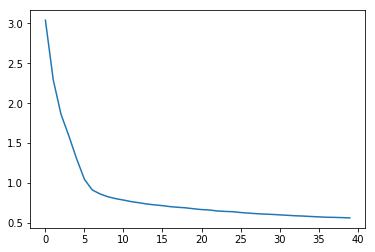

In [11]:
err2 = []

for epoch in range(30):
    e1, e2 = trainPredict()
    err2.append(e2)

    plt.clf()    
    plt.plot(err2)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)    
    
    # Save a checkpoint during training
    torch.save(predict.state_dict(), open("predict.th","wb"))
    
plt.close()

### Train the proposer

This code trains the proposer against the predictor for 1000 epochs. Since the proposer training isn't iterative over an entire dataset here, generally it will take more epochs to train but will be much faster in terms of computer time compared to training the predictor.

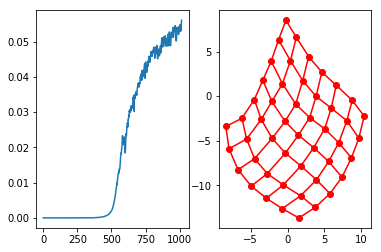

In [14]:
# Generate proposals out to 5 actions long
ACTION = 5

# Use a 7x7 control mesh
MESH = 7

# Use a regularization of 0.01
ALPHA = 0.01

PROPOSALS = MESH*MESH
err2s = []

for epoch in range(1000):
    # Train on action generation
    propose.zero_grad()
    
    iangles, states, acts, preds, sigma = getProposals()
    sigma = F.elu(sigma)+1.001
    
    acpu = acts.cpu().data.numpy()
    
    loss2 = measureMinDist(preds)
    gpreds = preds[:,0:2,:].view((1,2,MESH,MESH))
    
    # This smoothing term can be used as additional regularization
    # to help the grid be more uniform and untangled
    
    #smooth = torch.mean((gpreds[:,:,1:,:]-gpreds[:,:,:-1,:])**2 + (gpreds[:,:,:,1:]-gpreds[:,:,:,:-1])**2)
    
    loss = -loss2 + ALPHA*torch.mean(torch.log(sigma)) 
    
    err2 = loss2.cpu().data.numpy()[0]
    err2s.append(err2)
    loss.backward()
    
    propose.adam.step()
            
    plt.clf()
    
    plt.subplot(1,2,1)
    plt.plot(err2s)
    plt.subplot(1,2,2)
    preds = preds.cpu().data.numpy()
    grid = preds[0].reshape((SENSORS,MESH,MESH))
    
    for i in range(MESH):
        plt.plot(10*grid[0,:,i],10*grid[1,:,i],'r-')
        plt.plot(10*grid[0,i,:],10*grid[1,i,:],'r-')

    plt.plot(10*preds[0,0,:],10*preds[0,1,:],'ro')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)
    
    
    if epoch%10 == 0: # Save a checkpoint every 10 epochs
        torch.save(propose.state_dict(), open("propose.th","wb"))

plt.close()

### Gather proposer-based data

After training the proposer, it's good to gather data on the specific proposed policies and then go back and retrain the predictor.

In [16]:
# Generate 10 action long playouts for training the predictor and add to the data
# This adds 1000 examples from the current proposal network

ACTION = 10

for i in range(10):
    a,s = getProposerData()
    s = s.transpose(0,2,1)
    a = a.transpose(0,2,1)
    actions = np.concatenate([actions,a],0)
    seqs = np.concatenate([seqs,s],0)

np.save("actions.npy",actions)
np.save("seqs.npy",seqs)

### Results visualizations, etc

It's a good idea to make sure that the actual outcomes correspond to what the predictor thinks, so this section of code runs some playouts and looks at what happens.

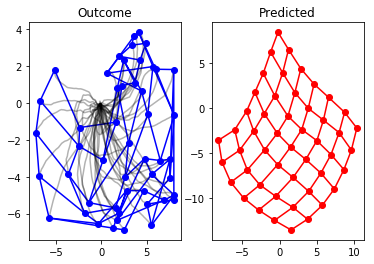

In [17]:
# Generate the playouts

ACTION = 5
MESH = 7
PROPOSALS = MESH*MESH

iangles, states, acts, preds, sigma = getProposals()

acpu = acts.cpu().data.numpy()
preds = preds.cpu().data.numpy()

outs, iseq = evalProposals(iangles, acpu, detail=True)

# Undo the scaling, so we visualize things in physical units
outs = outs*10
preds = preds*10

go = outs.reshape((SENSORS,MESH,MESH))
gp = preds.reshape((SENSORS,MESH,MESH))

plt.subplot(1,2,1)
for i in range(MESH):
    plt.plot(go[0,:,i],go[1,:,i],'b-')
    plt.plot(go[0,i,:],go[1,i,:],'b-')

for i in range(MESH*MESH):
    plt.plot(iseq[i,:,0,0], iseq[i,:,0,1],'k-',alpha=0.3)

plt.plot(outs[0,0,:],outs[0,1,:],'bo')
plt.title("Outcome")

plt.subplot(1,2,2)
for i in range(MESH):
    plt.plot(gp[0,:,i],gp[1,:,i],'r-')
    plt.plot(gp[0,i,:],gp[1,i,:],'r-')

plt.plot(preds[0,0,:],preds[0,1,:],'ro')
plt.title("Predicted")
plt.show()

### Watching a specific playout

The following code runs the pybullet GUI and plays out a specific action

In [18]:
# Open the simulation window

s = Simulation(np.zeros(18),gui=True)

In [19]:
# Set this to 0..48 to see a given policy played out
actidx = 0

# We just want to generate one at a time, so we get closed-loop control
ACTION = 1

# Play 5 steps of the given action policy
for i in range(5):    
    idx = 0
    state = s.getState().reshape((1,SENSORS))
    act,pred,sigma = propose.generate(tovar(state),predict,i)
    act = act.cpu().data.numpy()
    acts = act[0,:,:,actidx]
    
    states, istates = s.simulateActions(acts,ofs=200*i,inter=True,delay=0.01)#,delay=0.0)

In [20]:
# Close the simulation window
s.stop()